In [22]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from Ausgleichsbecken_class_file import Ausgleichsbecken_class

#importing pressure conversion function
current = os.path.dirname(os.path.realpath('Main_Programm.ipynb'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.pressure_conversion import pressure_conversion

In [23]:
# define constants

    # for physics
g                   = 9.81                                          # [m/s²]    gravitational acceleration 
rho                 = 1000.                                         # [kg/m³]   density of water 
pUnit_calc          = 'Pa'                                          # [text]    DO NOT CHANGE! for pressure conversion in print statements and plot labels 
pUnit_conv          = 'mWS'                                         # [text]    for pressure conversion in print statements and plot labels

    # for Turbine
Tur_Q_nenn          = 0.85                                          # [m³/s]    nominal flux of turbine 
Tur_p_nenn          = pressure_conversion(10.6,'bar',pUnit_calc)    # [Pa]      nominal pressure of turbine 
Tur_closingTime     = 90.                                           # [s]       closing time of turbine

    # for PI controller
Con_targetLevel     = 8.                                            # [m]
Con_K_p             = 0.1                                           # [-]       proportional constant of PI controller
Con_T_i             = 10.                                           # [s]       timespan in which a steady state error is corrected by the intergal term
Con_deadbandRange   = 0.05                                          # [m]       Deadband range around targetLevel for which the controller does NOT intervene

    # for pipeline
Pip_length          = 1000.                                         # [m]       length of pipeline
Pip_dia             = 0.9                                           # [m]       diameter of pipeline
Pip_area            = Pip_dia**2/4*np.pi                            # [m²]      crossectional area of pipeline
Pip_head            = 105.                                          # [m]       hydraulic head of pipeline without reservoir
Pip_angle           = np.arcsin(Pip_head/Pip_length)                # [rad]     elevation angle of pipeline 
Pip_n_seg           = 50                                            # [-]       number of pipe segments in discretization
Pip_f_D             = 0.014                                         # [-]       Darcy friction factor
Pip_pw_vel          = 500.                                          # [m/s]     propagation velocity of the pressure wave (pw) in the given pipeline
    # derivatives of the pipeline constants
Pip_dx              = Pip_length/Pip_n_seg                          # [m]       length of each pipe segment
Pip_dt              = Pip_dx/Pip_pw_vel                             # [s]       timestep according to method of characteristics
Pip_nn              = Pip_n_seg+1                                   # [1]       number of nodes
Pip_x_vec           = np.arange(0,Pip_nn,1)*Pip_dx                  # [m]       vector holding the distance of each node from the upstream reservoir along the pipeline
Pip_h_vec           = np.arange(0,Pip_nn,1)*Pip_head/Pip_n_seg      # [m]       vector holding the vertival distance of each node from the upstream reservoir

    # for reservoir
Res_area_base       = 74.                                           # [m²]      total base are of the cuboid reservoir   
Res_area_out        = Pip_area                                      # [m²]      outflux area of the reservoir, given by pipeline area
Res_level_crit_lo   = 0.                                            # [m]       for yet-to-be-implemented warnings
Res_level_crit_hi   = np.inf                                        # [m]       for yet-to-be-implemented warnings
Res_dt_approx       = 1e-3                                          # [s]       approx. timestep of reservoir time evolution to ensure numerical stability (see Res_nt why approx.)
Res_nt              = max(1,int(Pip_dt//Res_dt_approx))             # [1]       number of timesteps of the reservoir time evolution within one timestep of the pipeline
Res_dt              = Pip_dt/Res_nt                                 # [s]       harmonised timestep of reservoir time evolution

    # for general simulation
flux_init           = Tur_Q_nenn/1.1                                # [m³/s]    initial flux through whole system for steady state initialization  
level_init          = Con_targetLevel                               # [m]       initial water level in upstream reservoir for steady state initialization
simTime_target      = 1800.                                          # [s]       target for total simulation time (will vary slightly to fit with Pip_dt)
nt                  = int(simTime_target//Pip_dt)                   # [1]       Number of timesteps of the whole system
t_vec               = np.arange(0,nt+1,1)*Pip_dt                    # [s]       time vector. At each step of t_vec the system parameters are stored


In [24]:
# create objects

# Upstream reservoir
reservoir = Ausgleichsbecken_class(Res_area_base,Res_area_out,Res_dt,pUnit_conv,Res_level_crit_lo,Res_level_crit_hi,rho)
# print(reservoir.__init__.__doc__)
reservoir.get_info(full=True)
reservoir.set_steady_state(flux_init,level_init)
reservoir.get_info(full=True)

# initialize vectors
influx_vec      = np.full_like(t_vec,flux_init)
influx_vec[np.argmin(np.abs(t_vec-1200.)):] = 0.
outflux_vec     = np.zeros_like(t_vec)
outflux_vec[0]  = reservoir.get_current_outflux()
level_vec       = np.zeros_like(t_vec)
level_vec[0]    = reservoir.get_current_level()
volume_vec      = np.zeros_like(t_vec)
volume_vec[0]   = reservoir.get_current_volume()
pressure_vec    = np.full_like(t_vec,reservoir.get_current_pressure())
pressure_vec[np.argmin(np.abs(t_vec-1200.)):] = 0.

The cuboid reservoir has the following attributes: 
----------------------------- 
Base area             =       74.0       m² 
Outflux area          =       0.636      m² 
Current level         =       -inf       m
Critical level low    =       0.0        m 
Critical level high   =       inf        m 
Volume in reservoir   =       -inf       m³ 
Current influx        =       -inf       m³/s 
Current outflux       =       -inf       m³/s 
Current outflux vel   =       -inf       m/s 
Current pipe pressure =       -inf       mWS 
Simulation timestep   =       0.001      s 
Density of liquid     =       1000.0     kg/m³ 
----------------------------- 

The cuboid reservoir has the following attributes: 
----------------------------- 
Base area             =       74.0       m² 
Outflux area          =       0.636      m² 
Current level         =       8.0        m
Critical level low    =       0.0        m 
Critical level high   =       inf        m 
Volume in reservoir   =       592.0  

In [25]:
# time loop
for i in range(1,nt+1):
    reservoir.set_influx(influx_vec[i])
    reservoir.set_pressure(pressure_vec[i],display_warning=False)
    reservoir.set_outflux(outflux_vec[i-1],display_warning=False)
    for it_res in range(Res_nt):
        reservoir.timestep_reservoir_evolution()   
        
    outflux_vec[i] = reservoir.get_current_outflux()
    level_vec[i]   = reservoir.get_current_level()
    # pressure_vec[i]   = reservoir.get_current_pressure()

reservoir.get_info()

Exception: Reservoir ran emtpy

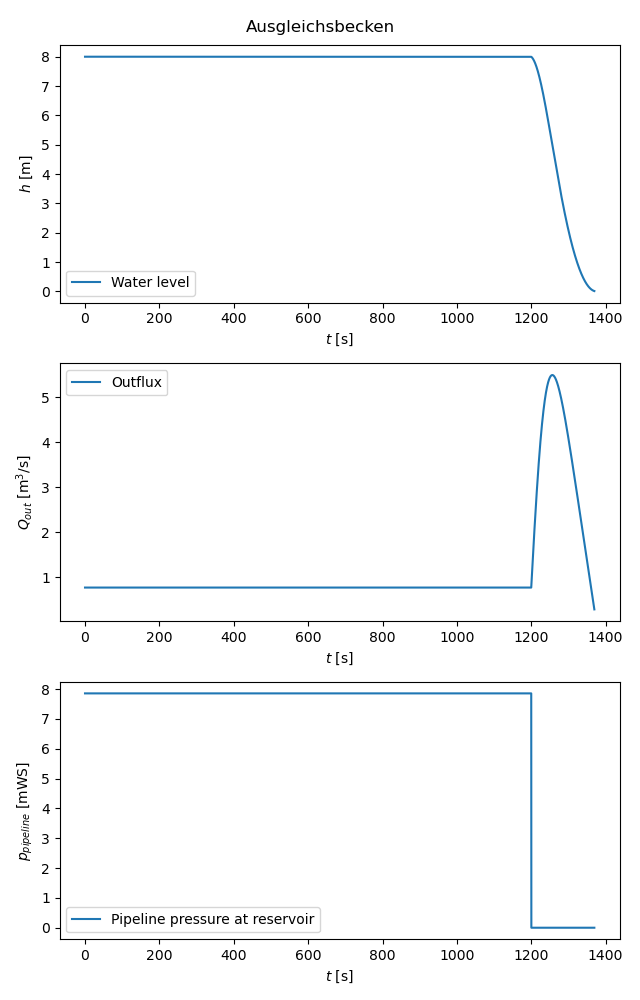

In [26]:
%matplotlib widget
fig1, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig1.set_figheight(10)
fig1.suptitle('Ausgleichsbecken')

ax1.plot(t_vec[:i],level_vec[:i], label='Water level')
ax1.set_ylabel(r'$h$ ['+reservoir.level_unit+']')
ax1.set_xlabel(r'$t$ ['+reservoir.time_unit+']')
ax1.legend()

ax2.plot(t_vec[:i],outflux_vec[:i], label='Outflux')
ax2.set_ylabel(r'$Q_{out}$ ['+reservoir.flux_unit+']')
ax2.set_xlabel(r'$t$ ['+reservoir.time_unit+']')
ax2.legend()

ax3.plot(t_vec[:i],pressure_conversion(pressure_vec[:i],'Pa',pUnit_conv), label='Pipeline pressure at reservoir')
ax3.set_ylabel(r'$p_{pipeline}$ ['+pUnit_conv+']')
ax3.set_xlabel(r'$t$ ['+reservoir.time_unit+']')
ax3.legend()


fig1.tight_layout()            